In [25]:
import numpy as np
import pandas as pd

In [26]:
# Load the dataset
dataset = pd.read_csv('train.csv', usecols=['sms', 'label'])
dataset.rename(columns={'sms': 'message'}, inplace=True)

In [27]:
dataset

,message,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1
5570,Will ü b going to esplanade fr home?\n,0
5571,"Pity, * was in mood for that. So...any other s...",0
5572,The guy did some bitching but I acted like i'd...,0


In [28]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  5574 non-null   object
 1   label    5574 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [29]:
dataset.describe()

,label
count,5574.000000
mean,0.134015
std,0.340699
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


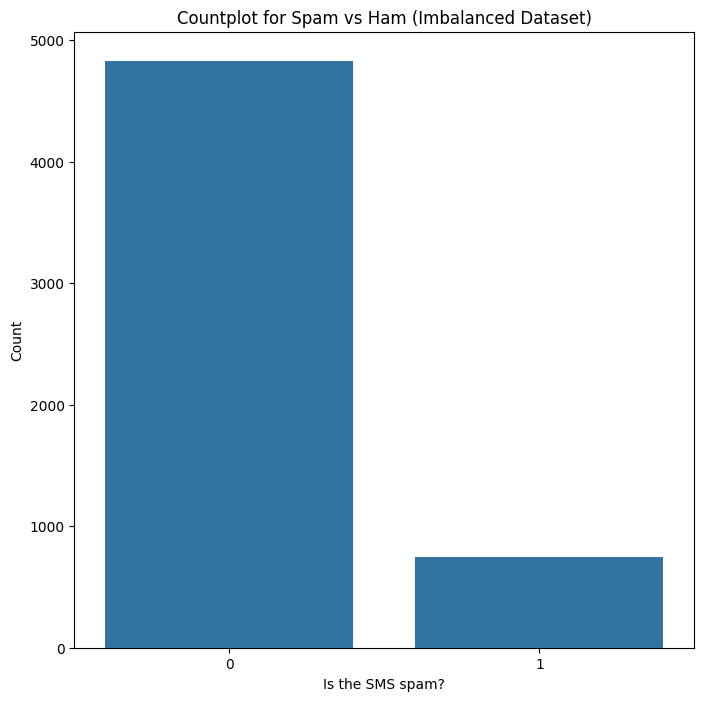

In [30]:
# Visualize data balance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8))
g = sns.countplot(x="label", data=dataset)
p = plt.title('Countplot for Spam vs Ham (Imbalanced Dataset)')
p = plt.xlabel('Is the SMS spam?')
p = plt.ylabel('Count')
plt.show()

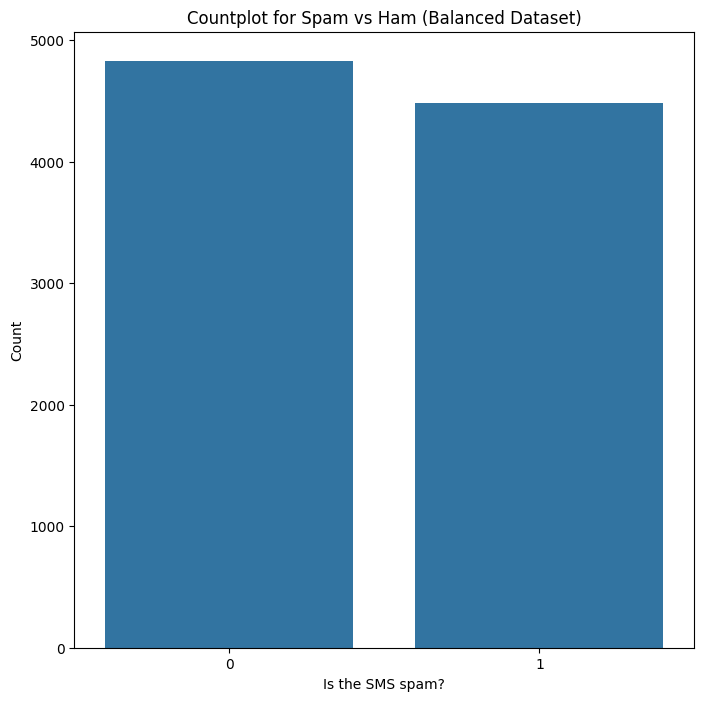

In [31]:
# Handling imbalanced dataset using oversampling
only_spam = dataset[dataset['label'] == 1]
count = int((dataset.shape[0] - only_spam.shape[0]) / only_spam.shape[0])

for i in range(0, count - 1):
    dataset = pd.concat([dataset, only_spam])

plt.figure(figsize=(8,8))
g = sns.countplot(x="label", data=dataset)
p = plt.title('Countplot for Spam vs Ham (Balanced Dataset)')
p = plt.xlabel('Is the SMS spam?')
p = plt.ylabel('Count')
plt.show()

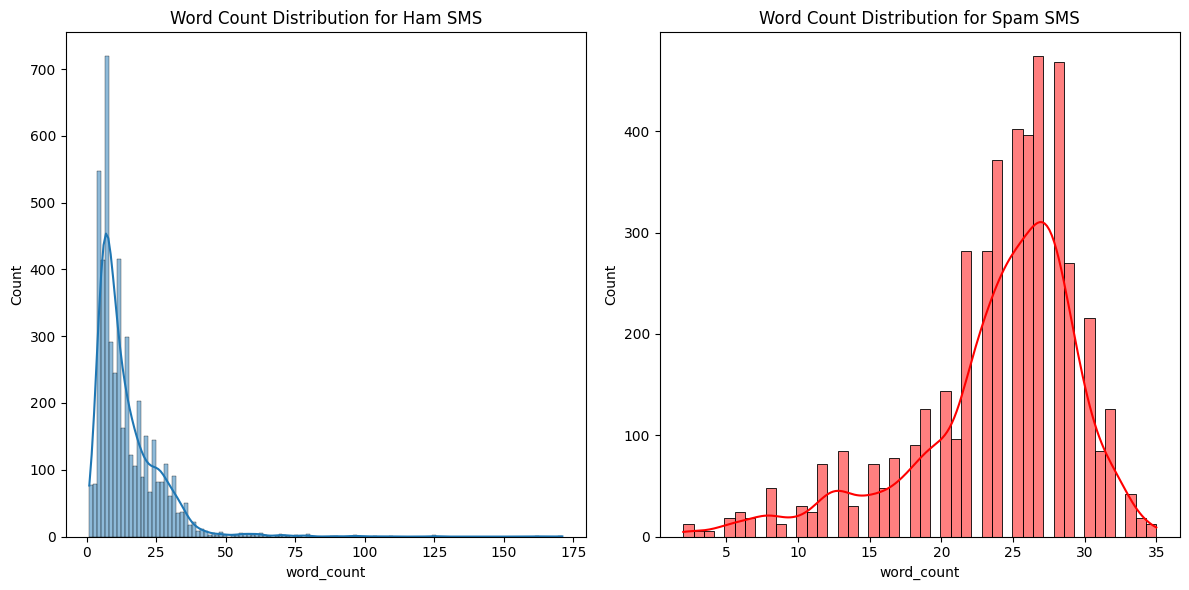

In [32]:
# Feature Engineering
# Word count
dataset['word_count'] = dataset['message'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
g = sns.histplot(dataset[dataset['label'] == 0].word_count, kde=True)
p = plt.title('Word Count Distribution for Ham SMS')

plt.subplot(1, 2, 2)
g = sns.histplot(dataset[dataset['label'] == 1].word_count, kde=True, color='red')
p = plt.title('Word Count Distribution for Spam SMS')
plt.tight_layout()
plt.show()



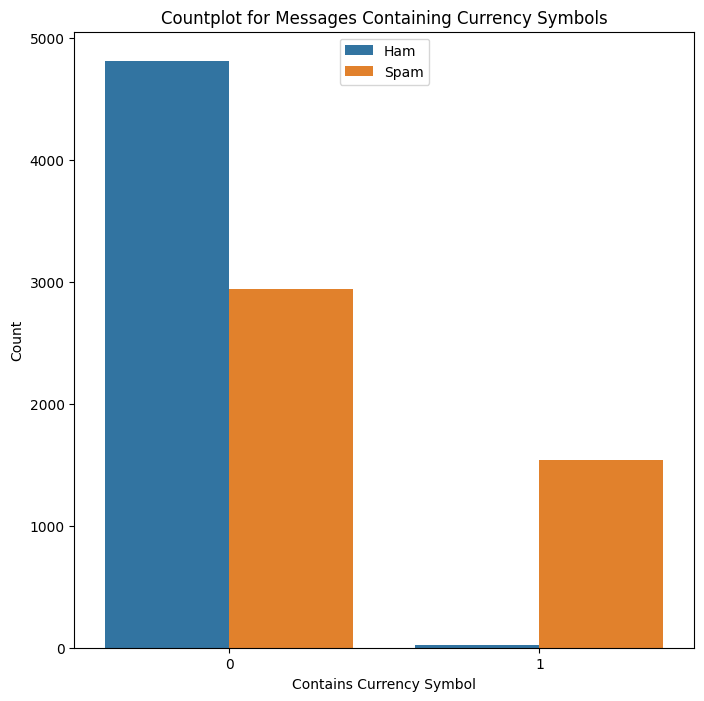

In [33]:
# Currency symbol feature
def contains_currency(data):
    currency_symbols = ['$', '£', '€', '₹']
    for symbol in currency_symbols:
        if symbol in data:
            return 1
    return 0

dataset['contains_currency_symbol'] = dataset['message'].apply(contains_currency)

plt.figure(figsize=(8,8))
g = sns.countplot(x="contains_currency_symbol", data=dataset, hue="label")
p = plt.title('Countplot for Messages Containing Currency Symbols')
p = plt.xlabel('Contains Currency Symbol')
p = plt.ylabel('Count')
p = plt.legend(['Ham', 'Spam'], loc=9)
plt.show()

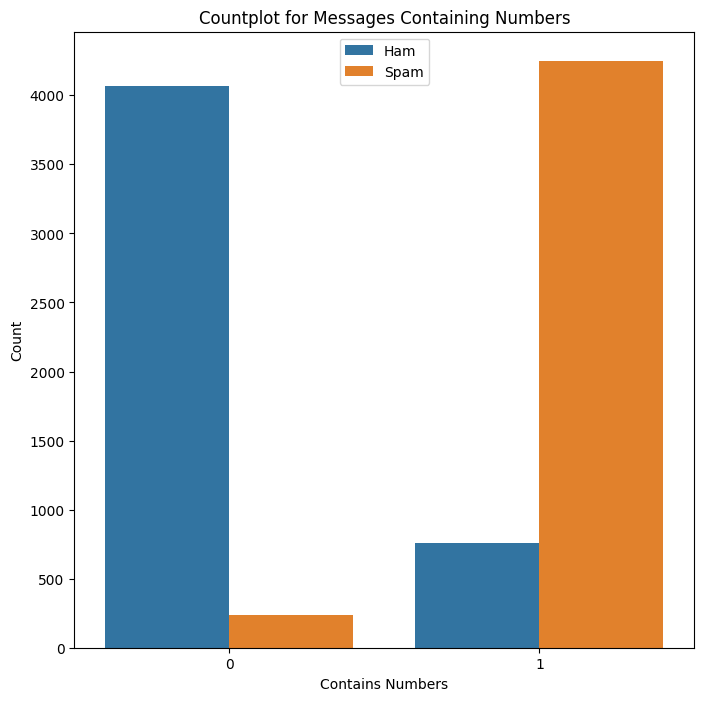

In [34]:
# Number feature
def contains_number(data):
    return int(any(char.isdigit() for char in data))

dataset['contains_number'] = dataset['message'].apply(contains_number)

plt.figure(figsize=(8,8))
g = sns.countplot(x="contains_number", data=dataset, hue="label")
p = plt.title('Countplot for Messages Containing Numbers')
p = plt.xlabel('Contains Numbers')
p = plt.ylabel('Count')
p = plt.legend(['Ham', 'Spam'], loc=9)
plt.show()

In [35]:
# Data cleaning
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

corpus = []
wnl = WordNetLemmatizer()

for sms in list(dataset['message']):
    message = re.sub(pattern='[^a-zA-Z]', repl=' ', string=sms)
    message = message.lower()
    message = message.split()
    message = [word for word in message if word not in set(stopwords.words('english'))]
    message = [wnl.lemmatize(word) for word in message]
    message = ' '.join(message)
    corpus.append(message)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
# Bag of Words Model
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=500)
vectors = tfidf.fit_transform(corpus).toarray()
feature_names = tfidf.get_feature_names_out()

X = pd.DataFrame(vectors, columns=feature_names)
Y = dataset['label']

In [37]:
# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [38]:
# Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train, Y_train)

MultinomialNB()

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       954
           1       0.94      0.93      0.94       908

    accuracy                           0.94      1862
   macro avg       0.94      0.94      0.94      1862
weighted avg       0.94      0.94      0.94      1862



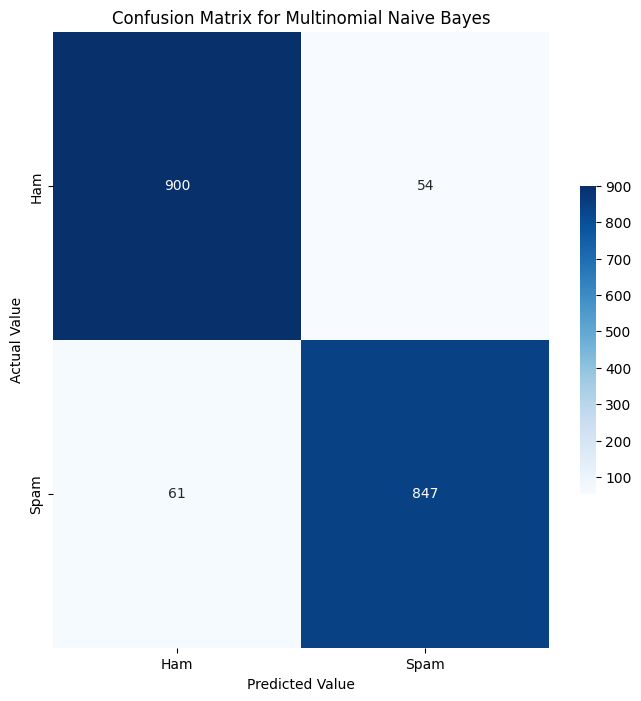

In [39]:
# Evaluate Naive Bayes
from sklearn.metrics import classification_report, confusion_matrix
y_pred = mnb.predict(X_test)
print(classification_report(Y_test, y_pred))

cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(8,8))
axis_labels = ['Ham', 'Spam']
g = sns.heatmap(data=cm, xticklabels=axis_labels, yticklabels=axis_labels, annot=True, fmt='g', cbar_kws={"shrink": 0.5}, cmap="Blues")
p = plt.title('Confusion Matrix for Multinomial Naive Bayes')
p = plt.xlabel('Predicted Value')
p = plt.ylabel('Actual Value')
plt.show()

In [40]:
# Decision Tree Model
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, Y_train)

DecisionTreeClassifier()

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       954
           1       0.98      0.99      0.99       908

    accuracy                           0.99      1862
   macro avg       0.99      0.99      0.99      1862
weighted avg       0.99      0.99      0.99      1862



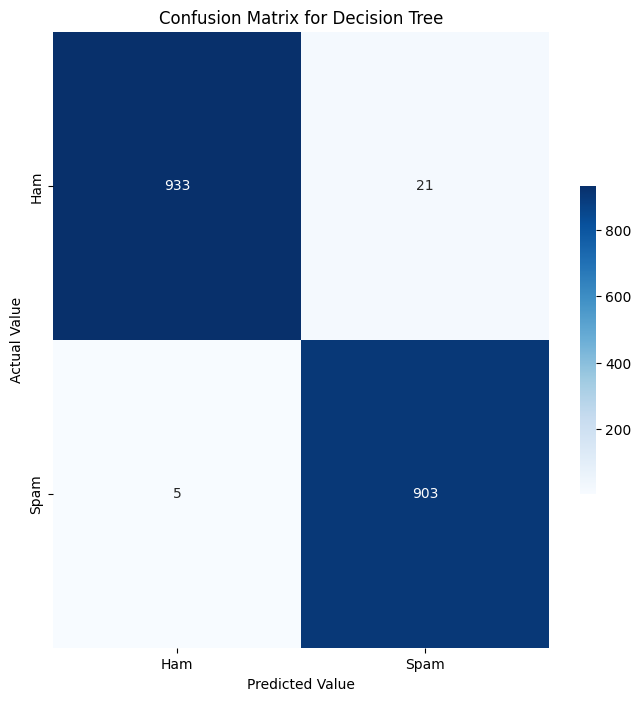

In [41]:
# Evaluate Decision Tree
y_pred1 = dtc.predict(X_test)
print(classification_report(Y_test, y_pred1))

cm = confusion_matrix(Y_test, y_pred1)
plt.figure(figsize=(8,8))
g = sns.heatmap(data=cm, xticklabels=axis_labels, yticklabels=axis_labels, annot=True, fmt='g', cbar_kws={"shrink": 0.5}, cmap="Blues")
p = plt.title('Confusion Matrix for Decision Tree')
p = plt.xlabel('Predicted Value')
p = plt.ylabel('Actual Value')
plt.show()

In [42]:
# Predict Spam Function
def predict_spam(sms):
    message = re.sub(pattern='[^a-zA-Z]', repl=' ', string=sms)
    message = message.lower()
    message = message.split()
    message = [word for word in message if word not in set(stopwords.words('english'))]
    message = [wnl.lemmatize(word) for word in message]
    message = ' '.join(message)
    temp = tfidf.transform([message]).toarray()
    return dtc.predict(temp)

In [43]:
# Prediction Example
sample_message = "Congratulations! You've won a $1,000 gift card! Click the link to claim your reward now: http://bit.ly/free-gift Offer expires soon. T&Cs apply."
if predict_spam(sample_message) == 1:
    print('This is a spam message')
else:
    print('This is a ham (normal) mess')

This is a spam message


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
